In [1]:
import serial
import csv

arduino_port = "COM5" #serial port of Arduino
baud = 115200 #arduino uno runs at 9600 baud
fileName="analog-data.csv" #name of the CSV file generated
ser = serial.Serial(arduino_port, baud)



In [ ]:
import csv
import serial
from time import sleep

arduino_port = "COM5"  # Replace with your actual port
fileName = "sensor_data.csv"

print("Connected to Arduino port: " + arduino_port)
file = open(fileName, "a")
print("Created file")

samples = 200
line = 0
sensor_data = []

# Column names for 5 sensors + label
column_names = ["Flex1", "Flex2", "Flex3", "Flex4", "Flex5",
                "accel_x","accel_y","accel_z","gyro_x","gyro_y","gyro_z",
                "Label"]
sensor_data.append(column_names)

# Start serial connection
ser = serial.Serial(arduino_port, 115200)

# Countdown before starting
print("Starting in:")
for i in range(5, 0, -1):
    print(i)
    sleep(1)
print("Start collecting data...")

boo = True

while line < samples:
    getData = ser.readline().decode().strip()
    readings = getData.split(",")

    # Ensure correct number of readings
    if len(readings) != 11:
        continue  # skip invalid lines

    # Add label and notify user
    if line < samples / 2:
        label = "normal"
        if line == 0:
            print("Label now: normal")
    else:
        label = "กำหมัด"
        if line == samples // 2:
            print("Label now: กำหมัด")
            print("Please กำหมัด (make a fist) now!")
            sleep(2)  # Wait for user to act

    readings.append(label)
    sensor_data.append(readings)
    print(readings)

    line += 1

# Save to CSV
with open(fileName, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(sensor_data)

print("Data collection complete!")
file.close()


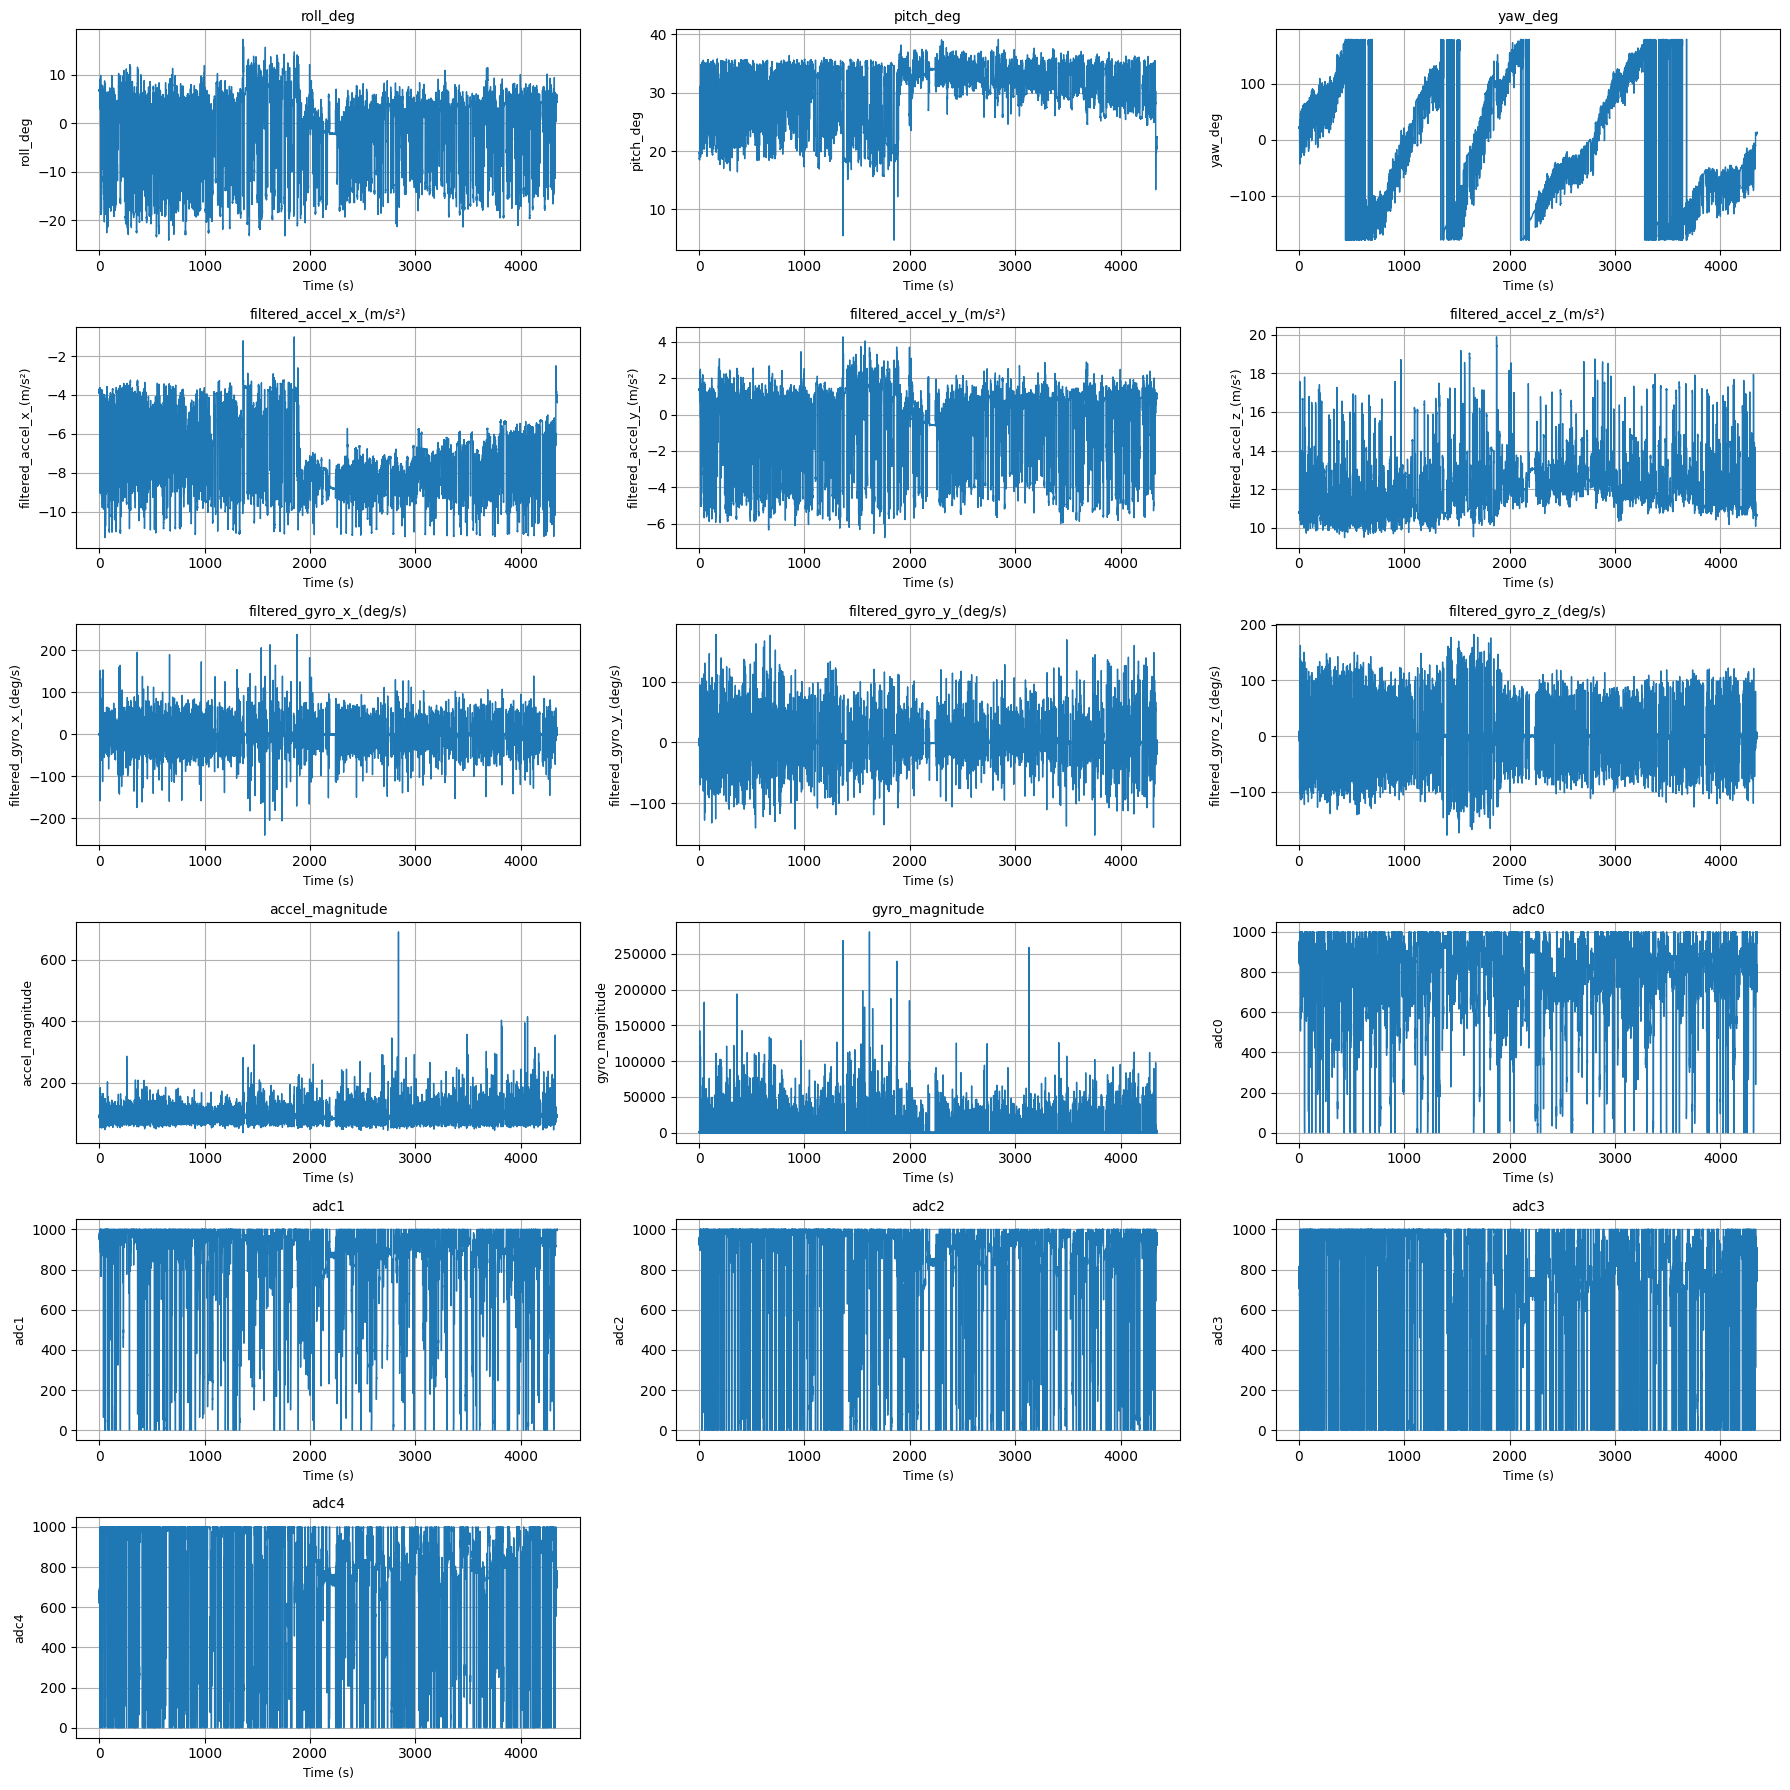

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
# file_path = "/mnt/data/data_v2_sensor.csv"
df = pd.read_csv(r'out_data\test_data\data_v2_sensor.csv')


# Convert timestamp from ms to seconds for better readability
df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0

# Sensor columns to plot
sensor_columns = [
    'roll_deg', 'pitch_deg', 'yaw_deg',
    'filtered_accel_x_(m/s²)', 'filtered_accel_y_(m/s²)', 'filtered_accel_z_(m/s²)',
    'filtered_gyro_x_(deg/s)', 'filtered_gyro_y_(deg/s)', 'filtered_gyro_z_(deg/s)',
    'accel_magnitude', 'gyro_magnitude',
    'adc0', 'adc1', 'adc2', 'adc3', 'adc4'
]

# Setup plot
num_plots = len(sensor_columns)
cols = 3
rows = -(-num_plots // cols)  # Ceiling division
fig, axs = plt.subplots(rows, cols, figsize=(18, rows * 3))
axs = axs.ravel()

# Plot each sensor
for i, col in enumerate(sensor_columns):
    axs[i].plot(df['time_s'], df[col], linewidth=1)
    axs[i].set_title(col, fontsize=10)
    axs[i].set_xlabel("Time (s)", fontsize=9)
    axs[i].set_ylabel(col, fontsize=9)
    axs[i].grid(True)

# Hide unused subplots
for j in range(len(sensor_columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


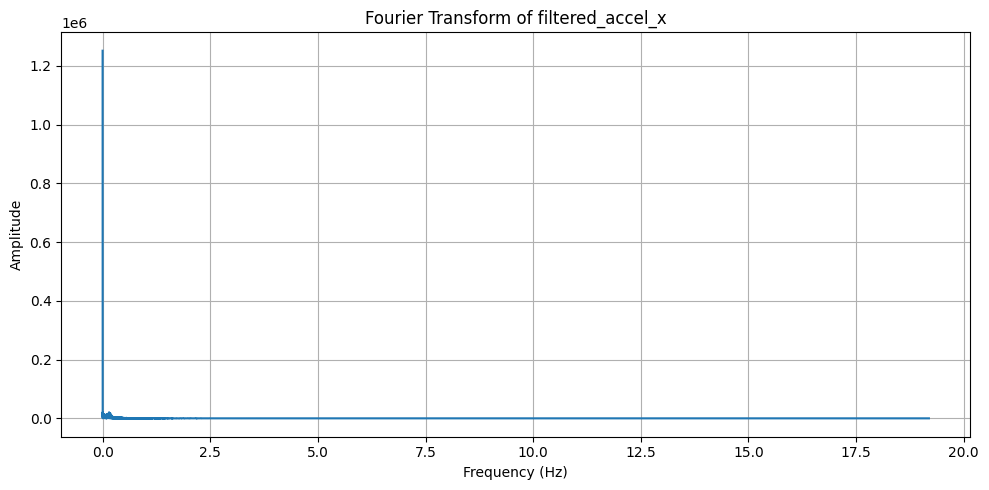

In [ ]:
import threading
import tkinter as tk
from tkinter import scrolledtext, messagebox, font as tkfont, ttk
import serial
import serial.tools.list_ports
import time
import os
import csv
from datetime import datetime

import cv2
from PIL import Image, ImageTk, ImageFont, ImageDraw # Added ImageFont, ImageDraw
import numpy as np # For converting PIL image back to OpenCV

# ─── CONFIGURATION ──────────────────────────────────────────────────────────
BAUDRATE                = 9600
FONT_FAMILY             = 'Consolas' # For Tkinter UI
FONT_SIZE_TEXT          = 11         # For Tkinter UI
FONT_SIZE_ENTRY         = 12         # For Tkinter UI

OUTPUT_DIR              = 'out_data'
VIDEO_FPS               = 20.0
SERIAL_TIMEOUT          = 1
BOARD_RESET_DELAY_MS    = 2000

# --- OpenCV Text & Font Configuration ---
# !!! IMPORTANT: YOU MUST CHANGE THIS PATH to a valid .ttf or .otf font file on your system that supports Thai.
# Examples:
# Windows: "C:/Windows/Fonts/tahoma.ttf" or "C:/Windows/Fonts/LeelawUI.ttf"
# Linux: "/usr/share/fonts/truetype/tlwg/Loma.ttf" (if tlwg-loma-ttf package is installed)
# macOS: "/System/Library/Fonts/Supplemental/Tahoma.ttf" or "/Library/Fonts/Ayuthaya.ttf"
THAI_FONT_PATH          = "tahoma.ttf" # <<< CHANGE THIS IF NEEDED! Or provide full path.
OPENCV_TEXT_FONT_SIZE_SMALL = 18
OPENCV_TEXT_FONT_SIZE_LARGE = 22 # For the main label text

DEFAULT_UNLABELED_VALUE = "notthing"
SELECTABLE_LABELS_LIST = [
    "ศูนย์", "หนึ่ง", "สอง", "สาม", "สี่", "ห้า", "หก", "เจ็ด", "แปด", "เก้า", "สิบ",
    "สิบเอ็ด", "สิบสอง", "สิบสาม", "สิบสี่", "สิบห้า", "สิบหก", "สิบเจ็ด", "สิบแปด", "สิบเก้า",
    "ยี่สิบ", "ยี่สิบเอ็ด", "ยี่สิบสอง", "ยี่สิบสาม", "ยี่สิบสี่", "ยี่สิบห้า", "ยี่สิบหก",
    "ยี่สิบเจ็ด", "ยี่สิบแปด", "ยี่สิบเก้า", "สามสิบ", "สามสิบเอ็ด"
]

column_names = [
    "timestamp_ms", "motion_detected",
    "roll_deg", "pitch_deg", "yaw_deg",
    "filtered_accel_x_(m/s²)", "filtered_accel_y_(m/s²)", "filtered_accel_z_(m/s²)",
    "filtered_gyro_x_(deg/s)", "filtered_gyro_y_(deg/s)", "filtered_gyro_z_(deg/s)",
    "accel_magnitude", "gyro_magnitude",
    "adc0", "adc1", "adc2", "adc3", "adc4", "Label"
]
os.makedirs(OUTPUT_DIR, exist_ok=True)

class SerialGUI:
    def __init__(self, master: tk.Tk):
        self.master = master
        self.master.title("Serial Monitor (Toggle Labeling, Commands, Sensor Data & Image)")

        # ... (other state variables as before) ...
        self.ser: serial.Serial | None = None
        self.alive: bool = False
        self.reader_thread: threading.Thread | None = None
        self.sensor_paused: bool = False
        self.record: bool = False
        self.sensor_data: list[list] = []
        self.text_record: str = "Not Recording"
        self.video_writer: cv2.VideoWriter | None = None
        self.output_filename_base: str | None = None
        self.current_time_ms: str = "0"

        self.current_selected_label_var = tk.StringVar()
        self.labeling_is_active: bool = False
        self.current_continuous_label: str = DEFAULT_UNLABELED_VALUE

        self.cap: cv2.VideoCapture = cv2.VideoCapture(0)
        self.image_label: tk.Label | None = None

        # --- Load Thai Font for OpenCV display ---
        self.cv_thai_font_small = None
        self.cv_thai_font_large = None
        if THAI_FONT_PATH and THAI_FONT_PATH.strip():
            try:
                self.cv_thai_font_small = ImageFont.truetype(THAI_FONT_PATH, OPENCV_TEXT_FONT_SIZE_SMALL)
                self.cv_thai_font_large = ImageFont.truetype(THAI_FONT_PATH, OPENCV_TEXT_FONT_SIZE_LARGE)
                print(f"Successfully loaded Thai font: {THAI_FONT_PATH}")
            except IOError:
                print(f"Error: Could not load Thai font from '{THAI_FONT_PATH}'. Thai text in OpenCV window may not display correctly.")
                print("Please ensure the THAI_FONT_PATH is correct and the font file exists.")
                self.cv_thai_font_small = None # Ensure it's None on failure
                self.cv_thai_font_large = None
        else:
            print("Warning: THAI_FONT_PATH is not set. Thai text in OpenCV window may not display correctly.")


        # --- Tkinter UI Setup (largely unchanged) ---
        self.master.rowconfigure(0, weight=0); self.master.rowconfigure(1, weight=0)
        self.master.rowconfigure(2, weight=1); self.master.rowconfigure(3, weight=0)
        self.master.rowconfigure(4, weight=0); self.master.columnconfigure(0, weight=1)
        self.master.columnconfigure(1, weight=1)

        self.text_font = tkfont.Font(family=FONT_FAMILY, size=FONT_SIZE_TEXT)
        self.entry_font = tkfont.Font(family=FONT_FAMILY, size=FONT_SIZE_ENTRY)

        port_frame = tk.Frame(master)
        port_frame.grid(row=0, column=0, columnspan=2, sticky="we", padx=10, pady=(10, 5))
        port_frame.columnconfigure(0, weight=0); port_frame.columnconfigure(1, weight=1)
        port_frame.columnconfigure(2, weight=0); port_frame.columnconfigure(3, weight=0)
        port_frame.columnconfigure(4, weight=0)
        tk.Label(port_frame, text="Port:", font=self.entry_font).grid(row=0, column=0, sticky="w")
        self.port_var = tk.StringVar()
        self.port_combo = ttk.Combobox(port_frame, textvariable=self.port_var, state='readonly', font=self.entry_font)
        self.port_combo.grid(row=0, column=1, sticky="we", padx=(5, 5))
        self.refresh_button = tk.Button(port_frame, text="Refresh", font=self.entry_font, command=self.refresh_ports)
        self.refresh_button.grid(row=0, column=2, sticky="e", padx=(5, 5))
        self.connect_button = tk.Button(port_frame, text="Connect", font=self.entry_font, command=self.connect_serial)
        self.connect_button.grid(row=0, column=3, sticky="e", padx=(5, 5))
        self.disconnect_button = tk.Button(port_frame, text="Disconnect", font=self.entry_font, command=self.disconnect_serial, state=tk.DISABLED)
        self.disconnect_button.grid(row=0, column=4, sticky="e")
        self.refresh_ports()

        label_frame = tk.Frame(master)
        label_frame.grid(row=1, column=0, columnspan=2, sticky="we", padx=10, pady=(0,5))
        label_frame.columnconfigure(0, weight=0); label_frame.columnconfigure(1, weight=1)
        tk.Label(label_frame, text="Toggle Label (Spacebar):", font=self.entry_font).grid(row=0, column=0, sticky="w", padx=(0,5))
        self.label_combo = ttk.Combobox(label_frame, textvariable=self.current_selected_label_var, values=SELECTABLE_LABELS_LIST, state='readonly', font=self.entry_font)
        if SELECTABLE_LABELS_LIST: self.current_selected_label_var.set(SELECTABLE_LABELS_LIST[0])
        self.label_combo.grid(row=0, column=1, sticky="we")
        self.master.bind("<space>", self.on_spacebar_press)
        self.label_combo.bind("<space>", self.on_spacebar_press)

        outer_pane = tk.PanedWindow(master, orient=tk.HORIZONTAL)
        outer_pane.grid(row=2, column=0, columnspan=2, sticky="nsew", padx=10, pady=5)
        left_pane = tk.PanedWindow(outer_pane, orient=tk.VERTICAL)
        # ... (rest of UI setup as before) ...
        left_pane.rowconfigure(0, weight=1); left_pane.columnconfigure(0, weight=1)
        top_frame = tk.Frame(left_pane)
        top_frame.rowconfigure(0, weight=0); top_frame.rowconfigure(1, weight=1); top_frame.columnconfigure(0, weight=1)
        tk.Label(top_frame, text="Commands / Status", font=(FONT_FAMILY, FONT_SIZE_TEXT + 2, "bold")).grid(row=0, column=0, sticky="w", pady=(0, 4))
        self.top_text = scrolledtext.ScrolledText(top_frame, wrap=tk.WORD, font=self.text_font, state=tk.DISABLED, bg='black', fg='lightyellow')
        self.top_text.grid(row=1, column=0, sticky="nsew")
        left_pane.add(top_frame, minsize=180)
        bottom_frame = tk.Frame(left_pane)
        bottom_frame.rowconfigure(0, weight=0); bottom_frame.rowconfigure(1, weight=0); bottom_frame.rowconfigure(2, weight=1)
        bottom_frame.columnconfigure(0, weight=1); bottom_frame.columnconfigure(1, weight=1)
        self.pause_button = tk.Button(bottom_frame, text="Pause Sensor", font=self.entry_font, command=self.toggle_pause_sensor)
        self.pause_button.grid(row=0, column=0, sticky="w", pady=(0, 6), padx=(0, 5))
        self.record_button = tk.Button(bottom_frame, text="Record", font=self.entry_font, command=self.toggle_record)
        self.record_button.grid(row=0, column=1, sticky="w", pady=(0, 6))
        tk.Label(bottom_frame, text="Sensor Data", font=(FONT_FAMILY, FONT_SIZE_TEXT + 2, "bold")).grid(row=1, column=0, columnspan=2, sticky="w", pady=(0, 4))
        self.bottom_text = scrolledtext.ScrolledText(bottom_frame, wrap=tk.WORD, font=self.text_font, state=tk.DISABLED, bg='black', fg='cyan')
        self.bottom_text.grid(row=2, column=0, columnspan=2, sticky="nsew")
        left_pane.add(bottom_frame, minsize=130)
        outer_pane.add(left_pane, stretch="always")
        image_frame = tk.LabelFrame(master, text="Camera Feed", padx=5, pady=5)
        image_frame.rowconfigure(0, weight=1); image_frame.columnconfigure(0, weight=1)
        self.image_label = tk.Label(image_frame)
        self.image_label.grid(row=0, column=0, sticky="nsew")
        outer_pane.add(image_frame, stretch="always")

        self.entry = tk.Entry(master, font=self.entry_font, state=tk.DISABLED)
        self.entry.grid(row=3, column=0, padx=(10, 5), pady=(0, 10), sticky="we")
        self.entry.bind("<Return>", lambda event: self.send_data())
        self.entry.bind("<space>", self.on_spacebar_press)
        self.send_button = tk.Button(master, text="Send", font=self.entry_font, command=self.send_data, state=tk.DISABLED, width=10)
        self.send_button.grid(row=3, column=1, padx=(0, 10), pady=(0, 10), sticky="e")
        self.close_button = tk.Button(master, text="Close", font=self.entry_font, command=self.close)
        self.close_button.grid(row=4, column=0, columnspan=2, pady=(0, 10))
        
        self.update_image()
        self.master.protocol("WM_DELETE_WINDOW", self.close)

    def on_spacebar_press(self, event=None):
        # ... (method unchanged from previous toggle implementation) ...
        if self.record:
            if not self.labeling_is_active:
                self.current_continuous_label = self.current_selected_label_var.get()
                if not self.current_continuous_label: self.current_continuous_label = DEFAULT_UNLABELED_VALUE
                self.labeling_is_active = True
                self._append_to_top(f"[Labeling STARTED] Applying '{self.current_continuous_label}' continuously.\n")
            else: 
                stopped_label = self.current_continuous_label
                self.labeling_is_active = False
                self._append_to_top(f"[Labeling STOPPED] Was applying '{stopped_label}'. Reverting to default.\n")
            return "break" 
        return None

    def update_image(self):
        if not self.cap.isOpened(): self.master.after(100, self.update_image); return
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame, 1) # Mirror

            # --- Text Overlay Logic ---
            use_pillow = self.cv_thai_font_small is not None and self.cv_thai_font_large is not None

            y_offset = 20 # Initial Y position for text
            line_spacing = 30

            if use_pillow:
                # Convert frame to PIL Image for Pillow drawing
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                draw = ImageDraw.Draw(pil_image)
                
                text_color_pil_green = (0, 255, 0) # Green for general info
                text_color_pil_yellow = (255, 255, 0) # Yellow for label status

                draw.text((15, y_offset), f"T: {self.current_time_ms} ms", font=self.cv_thai_font_small, fill=text_color_pil_green)
                y_offset += line_spacing
                draw.text((15, y_offset), self.text_record, font=self.cv_thai_font_small, fill=text_color_pil_green)
                y_offset += line_spacing

                if self.output_filename_base and self.record:
                    draw.text((15, y_offset), f"File: {self.output_filename_base}", font=self.cv_thai_font_small, fill=text_color_pil_green)
                    y_offset += line_spacing
            
                if self.record:
                    active_label_str = self.current_continuous_label if self.labeling_is_active else DEFAULT_UNLABELED_VALUE
                    label_status_str = " (ACTIVE)" if self.labeling_is_active else " (INACTIVE)" # "(ACTIVE)" / "(INACTIVE)" in Thai
                    full_label_display = f"Label: {active_label_str}{label_status_str}" # "Label:" in Thai

                    draw.text((15, y_offset), full_label_display, font=self.cv_thai_font_large, fill=text_color_pil_yellow)
                
                # Convert PIL Image back to OpenCV frame
                frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            
            else: # Fallback to cv2.putText if Thai font is not loaded
                font_cv = cv2.FONT_HERSHEY_SIMPLEX; thickness_cv = 2
                
                cv2.putText(frame, f"T: {self.current_time_ms} ms", (15, y_offset), font_cv, 0.7, (0,255,0), thickness_cv, cv2.LINE_AA) # BGR Green
                y_offset += line_spacing
                cv2.putText(frame, self.text_record, (15, y_offset), font_cv, 0.7, (0,255,0), thickness_cv, cv2.LINE_AA)
                y_offset += line_spacing

                if self.output_filename_base and self.record:
                    cv2.putText(frame, f"File: {self.output_filename_base}", (15, y_offset), font_cv, 0.6, (0,255,0), thickness_cv, cv2.LINE_AA)
                    y_offset += line_spacing
            
                if self.record:
                    active_label_str = self.current_continuous_label if self.labeling_is_active else DEFAULT_UNLABELED_VALUE
                    label_status_str = " (ACTIVE)" if self.labeling_is_active else " (INACTIVE)"
                    full_label_display = f"Label: {active_label_str}{label_status_str}" # English fallback
                    cv2.putText(frame, full_label_display, (15, y_offset), font_cv, 0.7, (0,255,255), thickness_cv, cv2.LINE_AA) # BGR Yellow


            # --- Video Writing and Display (Pillow image already converted back to 'frame') ---
            if self.record and self.video_writer: self.video_writer.write(frame)
            
            # --- Tkinter Image Update (Resizing and Display) ---
            cv2image_for_tk = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Use the (potentially modified by Pillow) frame
            pil_img_for_tk = Image.fromarray(cv2image_for_tk)
            
            w_lw = self.image_label.winfo_width(); h_lw = self.image_label.winfo_height()
            if w_lw <= 1 or h_lw <= 1: 
                h_orig_frame, w_orig_frame = frame.shape[:2] # Get dimensions from current frame
                w_lw, h_lw = w_orig_frame, h_orig_frame
            if w_lw <=1 or h_lw <=1: self.master.after(30, self.update_image); return

            w_p, h_p = pil_img_for_tk.size; img_ar = w_p / h_p; lbl_ar = w_lw / h_lw
            if img_ar > lbl_ar: new_w = w_lw; new_h = int(new_w / img_ar)
            else: new_h = h_lw; new_w = int(new_h * img_ar)
            new_w = max(1,new_w); new_h = max(1,new_h)
            try:
                rs_filter = Image.Resampling.LANCZOS if hasattr(Image,"Resampling") else Image.LANCZOS
                r_pil_img = pil_img_for_tk.resize((new_w,new_h), rs_filter)
            except Exception as e: print(f"Resize err: {e}"); self.master.after(30,self.update_image); return
            
            canvas = Image.new("RGB",(w_lw,h_lw),(0,0,0))
            x_off = (w_lw - new_w)//2; y_off = (h_lw - new_h)//2
            canvas.paste(r_pil_img,(x_off,y_off))
            imgtk = ImageTk.PhotoImage(image=canvas)
            self.image_label.imgtk = imgtk; self.image_label.configure(image=imgtk)

        self.master.after(30, self.update_image)

    # ... (refresh_ports, connect_serial, disconnect_serial methods unchanged) ...
    def refresh_ports(self):
        ports=[p.device for p in serial.tools.list_ports.comports()]
        self.port_combo['values']=ports
        if ports:
            if self.port_var.get() not in ports: self.port_var.set(ports[0])
        else: self.port_var.set('')
        if self.ser and self.ser.is_open:
            try: self.ser.write(b"reset\n"); self._append_to_top("[You] reset\n")
            except serial.SerialException as e: messagebox.showerror("Write Error",f"Failed to send reset:\n{e}")

    def connect_serial(self):
        selected=self.port_var.get().strip()
        if not selected: messagebox.showwarning("No Port Selected","Please select a serial port."); return
        try:
            self.ser=serial.Serial(selected,BAUDRATE,timeout=SERIAL_TIMEOUT)
            time.sleep(BOARD_RESET_DELAY_MS/1000.0)
        except serial.SerialException as e: messagebox.showerror("Connection Error",f"Could not open {selected!r}:\n{e}"); return
        self.port_combo.config(state='disabled'); self.refresh_button.config(state='disabled')
        self.connect_button.config(state='disabled'); self.disconnect_button.config(state=tk.NORMAL)
        self.entry.config(state=tk.NORMAL); self.send_button.config(state=tk.NORMAL)
        self._clear_panes(); self._append_to_top(f"[Arduino] *** Connected to {selected} @ {BAUDRATE} baud ***\n")
        try: self.ser.write(b"reset\n"); self._append_to_top("[You] reset\n")
        except serial.SerialException as e: messagebox.showerror("Write Error",f"Failed to send reset command:\n{e}")
        self.alive=True
        self.reader_thread=threading.Thread(target=self.read_from_serial,daemon=True); self.reader_thread.start()

    def disconnect_serial(self):
        if self.ser and self.ser.is_open:
            self.alive=False
            if self.reader_thread and self.reader_thread.is_alive(): self.reader_thread.join(timeout=2)
            try: self.ser.close()
            except Exception as e: self._append_to_top(f"[Error] Failed to close serial port: {e}\n")
        self.entry.config(state=tk.DISABLED); self.send_button.config(state=tk.DISABLED)
        self.port_combo.config(state='readonly'); self.refresh_button.config(state=tk.NORMAL)
        self.connect_button.config(state=tk.NORMAL); self.disconnect_button.config(state=tk.DISABLED)
        self._append_to_top("[Arduino] *** Disconnected ***\n")


    def read_from_serial(self):
        # ... (method unchanged from previous toggle implementation) ...
        while self.alive:
            try:
                if self.ser and self.ser.is_open and self.ser.in_waiting > 0:
                    raw = self.ser.readline().decode(errors='ignore').rstrip('\r\n')
                    if not raw: continue
                    if raw.startswith("[Sensor] "):
                        if not self.sensor_paused: self._append_to_bottom(raw + "\n")
                        raw_data = raw.replace('[Sensor] ', ''); readings = raw_data.split(",")
                        if readings: self.current_time_ms = readings[0]
                        if self.record:
                            converted = []
                            for item in readings:
                                try: val = float(item); val = int(val) if val.is_integer() else val
                                except ValueError: val = item 
                                converted.append(val)
                            label_for_this_row = DEFAULT_UNLABELED_VALUE
                            if self.labeling_is_active: label_for_this_row = self.current_continuous_label
                            converted.append(label_for_this_row)
                            self.sensor_data.append(converted)
                    else: self._append_to_top(raw + "\n")
                else: time.sleep(0.02)
            except (serial.SerialException, OSError) as e:
                if self.alive: self._append_to_top(f"[Error] Serial read error: {e}\n"); break
            except Exception as e:
                if self.alive: self._append_to_top(f"[Critical] Unexpected error in reader: {e}\n"); break
        self._append_to_top("[Info] Serial reader thread stopped.\n")

    # ... (send_data, toggle_pause_sensor, toggle_record, _finalize_recording_start, _save_sensor_data methods unchanged) ...
    def send_data(self):
        text=self.entry.get().strip()
        if not text or not self.ser or not self.ser.is_open: return
        try: self.ser.write((text+"\n").encode()); self._append_to_top(f"[You] {text}\n")
        except serial.SerialException as e: messagebox.showerror("Write Error",f"Failed to write: {e}")
        self.entry.delete(0,tk.END)

    def toggle_pause_sensor(self):
        self.sensor_paused = not self.sensor_paused
        self.pause_button.config(text="Resume Sensor" if self.sensor_paused else "Pause Sensor")

    def toggle_record(self):
        if not self.record: 
            if not self.ser or not self.ser.is_open:
                messagebox.showwarning("Not Connected","Connect to a serial port before recording."); return
            try: self.ser.write(b"set_time\n"); self._append_to_top("[You] set_time\n")
            except serial.SerialException as e: messagebox.showerror("Write Error",f"Failed to send set_time: {e}"); return
            self.sensor_data.clear()
            self.labeling_is_active = False
            self.current_continuous_label = DEFAULT_UNLABELED_VALUE 
            self._append_to_top("[Info] Waiting for board to sync time...\n"); self.master.update_idletasks()
            self.output_filename_base = datetime.now().strftime("%Y%m%d_%H%M%S")
            video_path = os.path.join(OUTPUT_DIR, f"{self.output_filename_base}.mp4")
            self.master.after(BOARD_RESET_DELAY_MS, lambda: self._finalize_recording_start(video_path))
        else: 
            self.record = False
            self.record_button.config(text="Record"); self.text_record = "Not Recording"
            if self.video_writer:
                self.video_writer.release(); self.video_writer = None
                self._append_to_top(f"[Info] Video recording stopped: {self.output_filename_base}.mp4\n")
            if self.labeling_is_active: 
                self._append_to_top(f"[Warning] Labeling of '{self.current_continuous_label}' was active and is now stopped due to recording stop.\n")
                self.labeling_is_active = False
                self.current_continuous_label = DEFAULT_UNLABELED_VALUE
            self._save_sensor_data()
            self.output_filename_base = None

    def _finalize_recording_start(self, video_path: str):
        if not (self.cap and self.cap.isOpened()):
            messagebox.showerror("Camera Error","Camera not available or not opened.")
            self._append_to_top("[Error] Camera not available for recording.\n")
            self.record_button.config(text="Record"); self.text_record = "Not Recording"
            self.output_filename_base = None
            self.labeling_is_active = False 
            self.current_continuous_label = DEFAULT_UNLABELED_VALUE
            return
        self.record = True; self.record_button.config(text="Stop Recording"); self.text_record = "Recording..."
        self._append_to_top(f"[Info] Recording started. Base filename: {self.output_filename_base}\n")
        width=int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 640
        height=int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 480
        fourcc=cv2.VideoWriter_fourcc(*'mp4v')
        try:
            self.video_writer=cv2.VideoWriter(video_path,fourcc,VIDEO_FPS,(width,height))
            if not self.video_writer.isOpened():
                messagebox.showerror("Video Writer Error",f"Could not open video writer for {video_path}.")
                self._append_to_top(f"[Error] Failed to open video writer for {video_path}\n")
                self.record=False; self.record_button.config(text="Record"); self.text_record="Not Recording"
                self.output_filename_base=None; self.video_writer=None
                self.labeling_is_active = False 
                self.current_continuous_label = DEFAULT_UNLABELED_VALUE
                return
        except Exception as e:
            messagebox.showerror("Video Writer Error",f"Exception creating video writer: {e}")
            self._append_to_top(f"[Error] Exception creating video writer: {e}\n")
            self.record=False; self.record_button.config(text="Record"); self.text_record="Not Recording"
            self.output_filename_base=None; self.video_writer=None
            self.labeling_is_active = False 
            self.current_continuous_label = DEFAULT_UNLABELED_VALUE
            return
        self._append_to_top(f"[Info] Video recording to: {video_path}\n")

    def _save_sensor_data(self):
        if not self.sensor_data or not self.output_filename_base:
            if self.output_filename_base : self._append_to_top("[Info] No sensor data to save.\n")
            return
        filepath = os.path.join(OUTPUT_DIR, f"{self.output_filename_base}_sensor.csv")
        try:
            with open(filepath, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile); writer.writerow(column_names); writer.writerows(self.sensor_data)
            self._append_to_top(f"[Info] Sensor data saved to: {filepath}\n")
        except IOError as e: self._append_to_top(f"[Error] Could not save sensor data: {e}\n"); messagebox.showerror("Save Error",f"Failed to save: {e}")
        except Exception as e: self._append_to_top(f"[Critical] Error saving sensor data: {e}\n"); messagebox.showerror("Save Error",f"Unexpected error: {e}")
        finally: self.sensor_data.clear()


    def close(self):
        # ... (method unchanged) ...
        if messagebox.askokcancel("Quit","Do you really want to quit?"):
            self.alive=False
            if self.reader_thread and self.reader_thread.is_alive(): self.reader_thread.join(timeout=2)
            if self.ser and self.ser.is_open:
                try: self.ser.close()
                except Exception: pass
            if self.video_writer: self.video_writer.release(); self.video_writer=None
            if self.cap and self.cap.isOpened(): self.cap.release()
            self.master.destroy()

    def _append_text_to_widget(self,widget:scrolledtext.ScrolledText,text:str):
        # ... (method unchanged) ...
        widget.configure(state=tk.NORMAL); widget.insert(tk.END,text); widget.see(tk.END); widget.configure(state=tk.DISABLED)
    def _append_to_top(self,text:str): self.master.after(0,lambda: self._append_text_to_widget(self.top_text,text))
    def _append_to_bottom(self,text:str): self.master.after(0,lambda: self._append_text_to_widget(self.bottom_text,text))
    def _clear_panes(self):
        # ... (method unchanged) ...
        def inner():
            for pane in(self.top_text,self.bottom_text):
                pane.configure(state=tk.NORMAL); pane.delete('1.0',tk.END); pane.configure(state=tk.DISABLED)
        self.master.after(0,inner)

if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("1100x730")
    gui = SerialGUI(root)
    root.mainloop()


Successfully loaded Thai font: tahoma.ttf


In [1]:
import random
from collections import Counter # For verification

SELECTABLE_LABELS_LIST = [
    "หนึ่ง", "สอง", "สาม", "สี่", "ห้า", "หก", "เจ็ด", "แปด", "เก้า", "สิบ"
]
desired_total_items = 100

num_unique_labels = len(SELECTABLE_LABELS_LIST)

if desired_total_items < num_unique_labels:
    print(f"Warning: Desired items ({desired_total_items}) is less than unique labels ({num_unique_labels}).")
    print("Selecting a random subset of labels without repetition.")
    balanced_random_list = random.sample(SELECTABLE_LABELS_LIST, desired_total_items)
else:
    # Calculate how many times each label should appear for perfect balance
    repetitions_per_label = desired_total_items // num_unique_labels

    # Create the base list with perfectly balanced items
    balanced_random_list = []
    for label in SELECTABLE_LABELS_LIST:
        balanced_random_list.extend([label] * repetitions_per_label)
    
    # Or a more Pythonic way for the above loop:
    # balanced_random_list = [label for label in SELECTABLE_LABELS_LIST for _ in range(repetitions_per_label)]


    # Calculate remaining items to be added to achieve the desired total
    remaining_items = desired_total_items % num_unique_labels

    if remaining_items > 0:
        # Randomly select 'remaining_items' unique labels from the original list
        # to add one more instance of each
        additional_labels = random.sample(SELECTABLE_LABELS_LIST, remaining_items)
        balanced_random_list.extend(additional_labels)

    # Shuffle the list to make the order random
    random.shuffle(balanced_random_list)

# --- Output and Verification ---
print(f"Generated list of {len(balanced_random_list)} items:")
# print(balanced_random_list) # Uncomment to see the full list

print("\nVerification of balance (counts per label):")
counts = Counter(balanced_random_list)
for label, count in sorted(counts.items(), key=lambda item: SELECTABLE_LABELS_LIST.index(item[0])) : # Sort by original list order
    print(f"- {label}: {count}")

if len(balanced_random_list) == desired_total_items:
    print(f"\nSuccessfully generated {desired_total_items} items.")
else:
    print(f"\nError: Generated {len(balanced_random_list)} items, but wanted {desired_total_items}.")

# Check if all original labels are present
all_present = all(label in counts for label in SELECTABLE_LABELS_LIST)
print(f"All original labels present: {all_present}")

Generated list of 100 items:

Verification of balance (counts per label):
- หนึ่ง: 10
- สอง: 10
- สาม: 10
- สี่: 10
- ห้า: 10
- หก: 10
- เจ็ด: 10
- แปด: 10
- เก้า: 10
- สิบ: 10

Successfully generated 100 items.
All original labels present: True


In [2]:
import pandas as pd
df = pd.read_csv(r"C:\SKB_co_Project\Sign_Language_Detection\Sign_Language_Detection\collect_data\out_data\2025-06-21\data\20250621_123804_session_sensor.csv")
df

,timestamp_ms,ax_slav,ay_slav,az_slav,gx_slav,gy_slav,gz_slav,angle_x_slav,angle_y_slav,angle_z_slav,...,gz,angle_x,angle_y,angle_z,flex_0,flex_1,flex_2,flex_3,flex_4,Label
0,292358,-1.0415,-3.2125,-9.2054,-0.0057,-0.0817,0.0387,-18.9712,-5.4901,160.1914,...,0.0138,24.4823,-7.1828,154.3506,291.91,298.23,241.83,103.35,134.91,nothing
1,292424,-0.8793,-3.0551,-9.4000,-0.0607,-0.0196,-0.0045,-18.4495,-5.2863,160.7551,...,0.0050,24.5725,-7.3036,154.2247,272.15,278.87,214.99,97.74,134.91,nothing
2,292490,-0.9793,-3.0814,-9.2647,-0.0421,-0.0014,-0.0453,-18.3762,-5.5061,160.7596,...,0.0484,24.6264,-7.9395,153.9601,242.52,269.19,255.25,114.57,143.59,nothing
3,292556,-0.8284,-3.1946,-9.3323,-0.0401,0.0149,-0.0701,-18.6030,-5.1525,160.6457,...,0.0538,25.0310,-6.4978,154.0248,262.28,269.19,228.41,92.13,130.57,nothing
4,292622,-0.9236,-3.1563,-9.2892,-0.0293,-0.0176,0.0270,-18.6419,-5.2652,160.5755,...,0.0777,25.2205,-6.6448,153.7981,252.40,230.47,188.16,75.31,126.23,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,363205,-1.1947,-3.0725,-9.2150,0.0555,-0.1153,0.0663,-18.3558,-6.7778,160.3481,...,0.0509,35.1913,-7.2816,143.8373,351.18,240.15,174.74,92.13,108.87,nothing
1074,363271,-0.9912,-3.2113,-9.3946,-0.0243,0.0567,-0.0211,-18.5678,-6.2356,160.3397,...,0.0315,34.9176,-7.1902,144.1319,331.42,211.12,174.74,108.96,121.89,nothing
1075,363337,-1.2193,-3.0629,-9.1797,0.0138,0.0586,-0.0279,-18.4365,-6.7048,160.2987,...,0.0624,35.3778,-6.9642,143.7347,341.30,240.15,214.99,103.35,117.55,nothing
1076,363403,-1.0319,-2.9833,-9.4730,0.0249,-0.0804,0.0020,-17.9065,-6.3156,160.9404,...,-0.0070,35.5463,-7.1528,143.5198,361.06,240.15,188.16,97.74,104.53,nothing
